# 6.4 例題: ベイズ多腕バンディット

In [49]:
using Distributions
using Plots
using Printf

In [2]:
struct Bandits
    p::Vector{Float64}
end

function pull(b::Bandits, i::T) where {T <: Integer}
    rand() < b.p[i]
end

length(b::Bandits) = Base.length(b.p)

length (generic function with 1 method)

In [3]:
x = Bandits([0.4, 0.2])

Bandits([0.4, 0.2])

In [4]:
pull(x, 2)

false

In [5]:
length(x)

2

In [60]:
mutable struct BayesianStrategy
    bandits::Bandits
    wins::Vector{Int64}
    trials::Vector{Int64}
    N::Int64
    choices::Vector{Float64}
    bb_score::Vector{Bool}
end

function BayesianStrategy(b::Bandits)
    n_bandits = length(b)
    BayesianStrategy(b, zeros(n_bandits), zeros(n_bandits), 0, [], [])
end

function sample_bandits(b::BayesianStrategy, n::Int64)
    bb_score = zeros(n)
    choices = zeros(n)
    for k in 1:n
        # バンディットの事前分布からサンプリングし、最も値の大きいサンプルを選択
        choice = argmax(rand.(Beta.(1 .+ b.wins, 1 .+ b.trials - b.wins)))
        
        # 選択されたバンディットからサンプリング
        result = pull(b.bandits, choice)
        
        b.wins[choice] += result
        b.trials[choice] += 1
        bb_score[k] = result
        b.N += 1
        choices[k] = choice
    end
    
    b.bb_score = [b.bb_score..., bb_score...]
    b.choices = [b.choices..., choices...]
    b
end

sample_bandits (generic function with 1 method)

In [61]:
y = BayesianStrategy(x)

BayesianStrategy(Bandits([0.4, 0.2]), [0, 0], [0, 0], 0, Float64[], Bool[])

In [62]:
sample_bandits(y, 3)

BayesianStrategy(Bandits([0.4, 0.2]), [0, 0], [1, 2], 3, [1.0, 2.0, 2.0], Bool[false, false, false])

In [63]:
function plot_priors(b::BayesianStrategy, prob::Vector{Float64})
    x = range(0.001, stop=0.999, length=200)
    wins = b.wins
    trials = b.trials
    
    betas = Beta.(1 .+ wins, 1 .+ trials .- wins)
    
    plt = plot()
    for i in 1:Base.length(prob)
        y = pdf.(betas[i], x)
        plot!(x, y, fillrange = 0, fillalpha = 0.3, label = "",
            title = @sprintf("Posterior after %d pull", b.N), titlefontsize=10)
    end
    plt
end

plot_priors (generic function with 1 method)

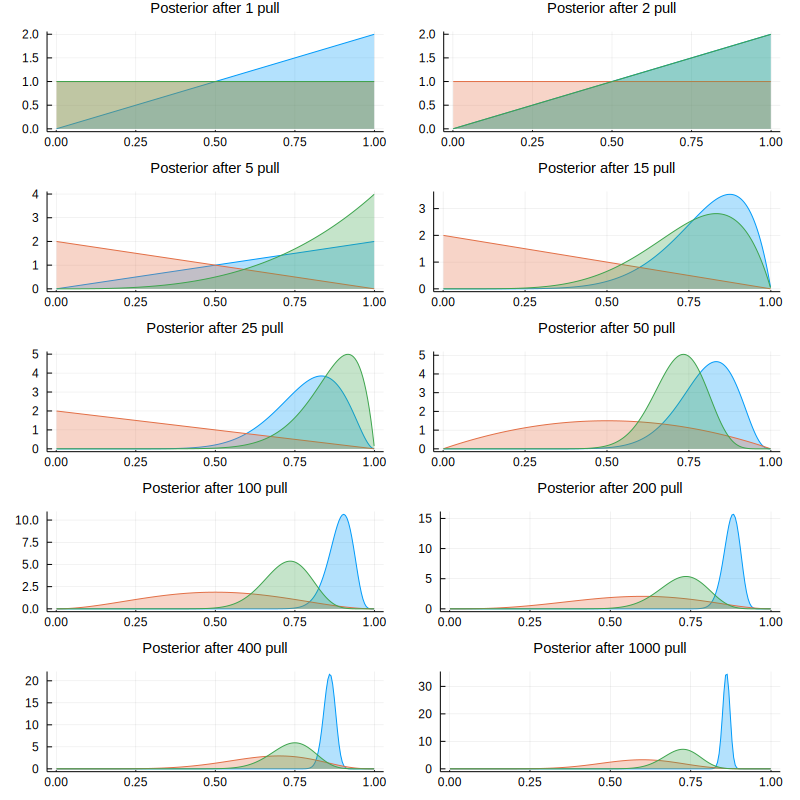

In [65]:
hidden_prob = [0.85, 0.60, 0.75]
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]
plts = []

for s in draw_samples
    sample_bandits(bayesian_strat, s)
    push!(plts, plot_priors(bayesian_strat, hidden_prob))
end

Plots.plot(plts..., layout = (5, 2), size = [800, 800])